In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
# physical parameters
q = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
#m = 6.6359437706294e-26 #(calcium)
kB = 1.38064852e-23 # J/K
f = 1.5e9 # Electrode frequency, in Hertz

### Note that the data is only a quarter of the plane. In order to get the E field data of the whole plane, i need to mirror the data to the other three quadrants to get the full information.

In [3]:
# loading E field (vector)
data = np.loadtxt("etrap_65V_1p5GHz_realsmoothExEy_250nm_30passes_quarter.fld", skiprows = 2)

In [26]:
# manipulating E field data
df = pd.DataFrame(data, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max, x_min = df.x.max(), df.x.min()
y_max, y_min = df.y.max(), df.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx, Ny = df.x.nunique() - 1, df.y.nunique() - 1 # numbers of intervals that divide each dimension
dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size
print("x_max = ", x_max*1.0e3, "mm")
print("y_max = ", y_max*1.0e3, "mm")
print("x_min = ", x_min*1.0e3, "mm")
print("y_min = ", y_min*1.0e3, "mm")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um")

x_max =  1.0 mm
y_max =  1.5 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


x     0.000000
y     0.000000
z     0.000000
Ex    0.169965
Ey   -0.068687
Ez    0.000000
Name: 0, dtype: float64


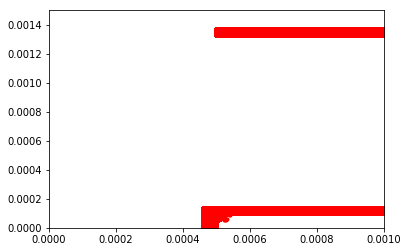

In [6]:
electrode = df.loc[(np.abs(df["Ex"]) < 1.0e-8) & (np.abs(df["Ey"]) < 1.0e-8)]
x_electrode = electrode.iloc[:, 0].values
y_electrode = electrode.iloc[:, 1].values
plt.plot(x_electrode, y_electrode, "r.")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
print(df.iloc[0, :])

In [28]:
def get_row_index(x, y):
    # given spatial coordinates x and y, 
    # output the index of the row corresponding to the coordinates
    # this only works for the first quadrant
    if x > x_max:
        x = x_max
    if x < x_min:
        x = x_min
    if y > y_max:
        y = y_max
    if y < y_min:
        y = y_min
    i = int((x - x_min) / dx)
    j = int((y - y_min) / dy)
    return i * (Ny + 1) + j
# n = get_row_index(-0.000381, 0.000275)
# print(n)
# print(df.iloc[n, :])

def grad_Ex(x, y):
    # return the gradient of x component of electric field at position (x, y);
    # used to interpolate E field between grid points
    # note that x, y are supposed to be on grid intersections.
    # Works for all four quadrants
    x, y = abs(x), abs(y)
    n = get_row_index(x, y)
    if x == x_max:
        nx = get_row_index(x-dx, y)
        x_deriv = (df.iloc[n,3] - df.iloc[nx,3])/(dx)
    else:
        nx = get_row_index(x+dx, y)
        x_deriv = (df.iloc[nx,3] - df.iloc[n,3])/(dx)
    if y == y_max:
        ny = get_row_index(x, y-dy)
        y_deriv = (df.iloc[n,3] - df.iloc[ny,3])/(dy)
    else:
        ny = get_row_index(x, y+dy)
        y_deriv = (df.iloc[ny,3] - df.iloc[n,3])/(dy)
    return (x_deriv, y_deriv)

def grad_Ey(x, y):
    # return the gradient of x component of electric field at position (x, y);
    # used to interpolate E field between grid points
    # note that x, y are supposed to be on grid intersections
    x, y = abs(x), abs(y)
    n = get_row_index(x, y)
    if x == x_max:
        nx = get_row_index(x-dx, y)
        x_deriv = (df.iloc[n,4] - df.iloc[nx,4])/(dx)
    else:
        nx = get_row_index(x+dx, y)
        x_deriv = (df.iloc[nx,4] - df.iloc[n,4])/(dx)
    if y == y_max:
        ny = get_row_index(x, y-dy)
        y_deriv = (df.iloc[n,4] - df.iloc[ny,4])/(dy)
    else:
        ny = get_row_index(x, y+dy)
        y_deriv = (df.iloc[ny,4] - df.iloc[n,4])/(dy)
    return (x_deriv, y_deriv)


def E_field(x, y, t):
    # return the electric field at position (x, y) at time t
    x = abs(x)
    y = abs(y)
    n = get_row_index(x, y)
    x0, y0 = df.iloc[n, 0], df.iloc[n, 1]
    Ex0, Ey0 = df.iloc[n, 3], df.iloc[n, 4]
    Ex = Ex0 + grad_Ex(x0, y0)[0] * (x-x0) + grad_Ex(x0, y0)[1] * (y-y0)
    Ey = Ey0 + grad_Ey(x0, y0)[0] * (x-x0) + grad_Ey(x0, y0)[1] * (y-y0)
    return (Ex*np.cos(2*np.pi*f*t), Ey*np.cos(2*np.pi*f*t))

def acceleration(x, y, t):
    Ex, Ey= E_field(x, y, t)
    return np.array([Ex*q/m, Ey*q/m])

def within_boundary(x, y):
    x, y = abs(x), abs(y)
    # check whether the x, y, z coordinate of an electron is within
    # our area of interest.
    n = get_row_index(x, y)
    #return x<x_max and x>x_min and y<y_max and y>y_min
    return x<x_max and y<y_max and \
(abs(df.iloc[n, 3]) >= 1.0e-7 or abs(df.iloc[n, 4]) >= 1.0e-7) 

def rk4(y, time, dt, derivs): 
    f0 = derivs(y, time)
    fhalf_bar = derivs(y+f0*dt/2, time+dt) 
    fhalf = derivs(y+fhalf_bar*dt/2, time+dt)
    f1_bar= derivs(y+fhalf*dt, time+dt)
    y_next = y+dt/6*(f0+2*fhalf_bar+2*fhalf+f1_bar)
    return y_next

def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0]
    g1 = acceleration(x, y, time)
    return np.array([g0, g1])

def trapped(rou, phi, v, theta, dt, t_max):

    electron_pos=np.array([rou*np.cos(phi), rou*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    trapped = True
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not within_boundary(x, y):
            trapped = False
            break
        state = rk4(state, t, dt, E_field_sim)
        t += dt
    return trapped

def Boltzmann_sim(N_ion_samples, T, dt, t_max, FWHM):
    # Simulate ion in the trap with initial condition characterized by a 
    # Boltzmann distribution of temperature T. The simulation (using RK4) step size 
    # is dt, and the maximum time duration of the simulation is t_max. The initial position
    # of the ion is characterized by a Gaussian distribution with full-width-half max FWHM.
    # the function returns a list of length N_ion_sample. 
    # The ith element of the list is 1 iff the ith ion is successfully trapped and is 0 if 
    # the ion escaped.
    class Boltzmann(stats.rv_continuous):
        def _pdf(self, v):
            return m*v*np.exp((-1/2*m*v**2)/(kB*T))/(kB*T)
    result = []
    Boltzmann_dist = Boltzmann(a=0)
    for i in range(N_ion_samples):
        rou = abs(np.random.normal(0, FWHM/2.355))
        phi = np.random.uniform(0, np.pi*2)
        v = Boltzmann_dist.rvs()
        theta = np.random.uniform(0, np.pi*2)
        if trapped(rou, phi, v, theta, dt, t_max):
            result.append(1)
        else:
            result.append(0)
        if i % 20 == 0:
            print(i+1, " electron samples already simulated")
    print("T: ", T, "Kelvin")
    print("N_samples: ", N_ion_samples)
    print("Time step: ", dt*1.0e9, "ns")
    print("Max Sim Time: ", t_max*1.0e6, "us")
    print("FWHM: ", FWHM*1.0e6, "um")
    print("Trapping Rate: ", np.mean(result), "+/-", np.std(result)/np.sqrt(len(result)))
    print("------")
    return result
    
    

In [24]:
n = get_row_index(0.0000381, 0.0000275)
print(n)
print(df.iloc[n, :])


912262
x        0.000038
y        0.000027
z        0.000000
Ex   -4151.083341
Ey    3030.008458
Ez       0.000000
Name: 912262, dtype: float64


## Single Particle Simulation

x_max =  1000.0 um
y_max =  1500.0 um
x_min =  0.0 um
y_min =  0.0 um
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um
Time step for simulation:  0.01 ns
Simulation time duration:  0.05 us
time: 8.368296384811401


Text(0, 0.5, 'y (um)')

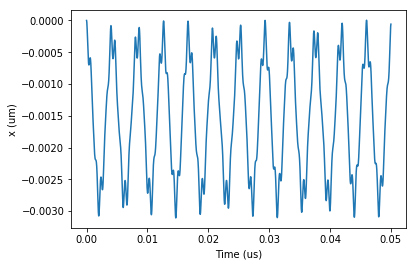

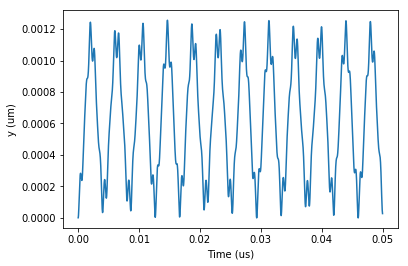

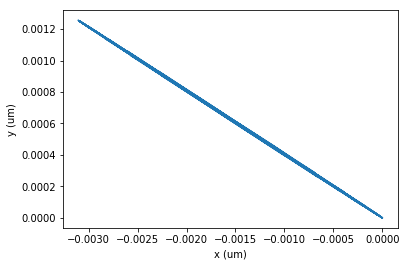

In [25]:
start = time.time()
# simulation configuration
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

T = 300.0 # kelvin
rou = 0.0 # distance from initial position to the trap center
phi = 0.0 # direction of initial position vector
v = 0.0 #speed
theta = 0.0 # direction of initial velocity

electron_pos=np.array([rou*np.cos(phi), rou*np.sin(phi)])
electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
state = np.array([electron_pos, electron_vel])
t = 0.0 # the time variable
x_traj = []
y_traj = []
t_s = []
trapped = True

# actual simulation
while t < t_max:
    x, y = state[0]
    if not within_boundary(x, y):
        print("out of bound")
        trapped = False
        break
    x_traj.append(x)
    y_traj.append(y)
    t_s.append(t)
    state = rk4(state, t, dt, E_field_sim)
    t += dt
x_traj, y_traj, t_s = np.array(x_traj), np.array(y_traj), np.array(t_s)

print("x_max = ", x_max*1.0e6, "um")
print("y_max = ", y_max*1.0e6, "um")
print("x_min = ", x_min*1.0e6, "um")
print("y_min = ", y_min*1.0e6, "um")
print("spatial resolution x: ", dx*1.0e6, "um")
print("spatial resolution y: ", dy*1.0e6, "um")
print("Time step for simulation: ", dt*1.0e9, "ns")
print("Simulation time duration: ", round(t*1.0e6, 3), "us")
end = time.time()
print("time:", end-start)

plt.figure()
plt.plot(t_s*1.0e6, x_traj*1.0e6)
plt.xlabel("Time (us)")
plt.ylabel("x (um)")

plt.figure()
plt.plot(t_s*1.0e6, y_traj*1.0e6)
plt.xlabel("Time (us)")
plt.ylabel("y (um)")

plt.figure()
plt.plot(x_traj*1.0e6, y_traj*1.0e6)
plt.xlabel("x (um)")
plt.ylabel("y (um)")

## $\rho$ Dependence

Simulating T =  300.0 kelvin
The result for T =  300.0 kelvin:
Simulating T =  0.01 kelvin
The result for T =  0.01 kelvin:
Simulating T =  10.0 kelvin
The result for T =  10.0 kelvin:
Simulating T =  4.0 kelvin
The result for T =  4.0 kelvin:


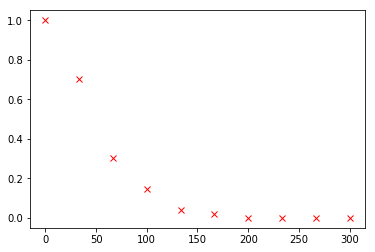

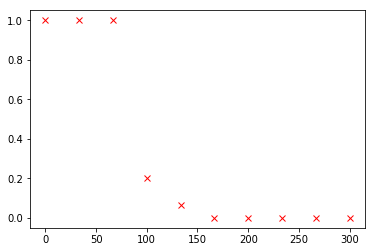

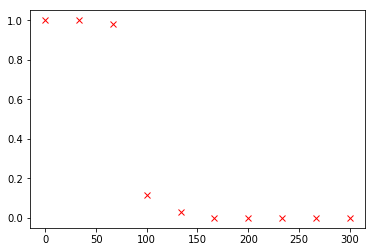

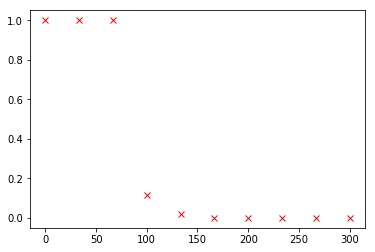

In [29]:
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

#initial condition
rou_s = np.linspace(0, 300.0e-6, 10)
N_phi = 5
N_theta = 19

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rou in rou_s
success_rate = dict() 
errors = dict()
for T in [300.0, 0.01, 10.0, 4.0]:
    v = np.sqrt(kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rou in rou_s:
        result = []
        for phi in np.linspace(0, np.pi/2, N_phi):
            for theta in np.linspace(0, np.pi*2, N_theta):
                if trapped(rou, phi, v, theta, dt, t_max):
                    result.append(1)
                else:
                    result.append(0)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_phi*N_theta))
    print("The result for T = ", T, "kelvin:")
    plt.figure()
    plt.plot(rou_s*1.0e6, success_rate[T], 'rx')
    

Text(0.5, 1.0, 'Rho Dependence')

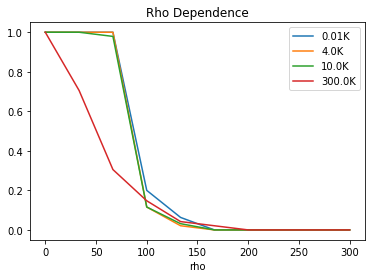

In [31]:
for T in [0.01, 4.0, 10.0, 300.0]:
    plt.plot(rou_s*1.0e6, success_rate[T], label = str(T) + "K")
    plt.xlabel("rho")
plt.legend()
plt.title("Rho Dependence")